# Lab 7: Fractal Dimension of Natural Disturbance
In [1990](https://doi.org/10.1016/0375-9601(90)90328-L) Bak, Chen and Tang proposed a cellular automaton that is an abstract model of a forest fire. Each cell is in one of three states: empty, occupied by forest, or on fire.

3 ecological processes is modelled: forest re-growth, fire ignition, and fire spread

  * empty cells "regenerate" forest at a fixed rate
  * forest fires ignite with a regular but small frequency
  * forested cells catch fire when their neighbours are burning, and burn our in one time step.

In this lab we will write a program that implements this model as a CA and look at the stable landscape patterns that emerge.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import correlate2d
from scipy.stats import linregress

if not os.path.exists('utils.py'):
  !wget  https://raw.githubusercontent.com/pearcej/complex-colab/master/notebooks/utils.py
if not os.path.exists('Cell2D.py'):
  !wget  https://raw.githubusercontent.com/pearcej/complex-colab/master/notebooks/Cell2D.py
from Cell2D import Cell2D, draw_array

--2022-03-06 17:38:29--  https://raw.githubusercontent.com/pearcej/complex-colab/master/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2645 (2.6K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.58K  --.-KB/s    in 0s      

2022-03-06 17:38:30 (23.8 MB/s) - ‘utils.py’ saved [2645/2645]

--2022-03-06 17:38:30--  https://raw.githubusercontent.com/pearcej/complex-colab/master/notebooks/Cell2D.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2628 (2.6K) [text/plain]
Saving 

## Data Definitions
let's improve on the textbook's somewhat terse code style and define names for the 3 possible cell states, and a colour map that maps each cell state to an intuitive colour.

In [2]:
EMPTY = 0
OCCUPIED = 1
FIRE = 10

cmap = [(0,0,0) for _ in range(11)]
cmap[EMPTY] = (1, 0.5, 0)    # brown
cmap[OCCUPIED] = (0,  1, 0)  # green
cmap[FIRE] = (1,  0, 0)      # red

forest_colour_map = mpl.colors.ListedColormap(cmap)

## The Cellular Automata
We'll extend the Cell2D CA, and define the step function to implement the 4 rules:
  *  An empty cell becomes occupied with probability p.

  *  A cell with a tree burns if any of its neighbors is on fire.

  *  A cell with a tree spontaneously burns, with probability f, even if none of its neighbors is on fire.

  *  A cell with a burning tree becomes an empty cell in the next time step.

Typical values for the parameters are p=0.01 and f=0.001.

In [3]:
class ForestFire(Cell2D):
  """ 2D Cellular Automaton that simulates a fire-dominated landscape """

  # TODO: define a corelation kernel

  def __init__(self, n, p=0.01, f=0.001, q=0.5):
    """Initializes the attributes.

    n: number of rows
    p: probability an empty cells becomes "forested" (occupied)
    f: probability of spontaneous file (e.g., 1/fire ignition interval)
    q: initial forest density (probability cell is "forested" in initial state)
    """
    # TODO: define internal model state variables and initialize landscape with approx. q proportion of cells OCCUPIED

  def step(self):
    """Executes one time step, applying the CA rules to regnerate empty cells and spread fire to occupied neighbours."""
    # TODO: define the rules for the CA.  This is a significant challenge b/c there are 4 rules and they must act independently!

  def num_occupied(self):
    """ return the number of cells occupied by forest """
    return 0  # TODO: count the number of forested cells.

  def pct_occupied(self):
    """ return the proportion of cells occupied by forest """
    return self.num_occupied()/self.size

  def draw(self):
    """Draws the CA cells using the forest colour map so values are coloured intuitively."""
    plt.axes().set_title("Occupied: {}%".format(round(self.pct_occupied()*100, 2)))
    draw_array(self.array, cmap=forest_colour_map, vmin=0, vmax=len(forest_colour_map.colors))

## Animation
Create a simple animation (using Cell2d.animate method) so we can visualize and verify the system dynamics

In [4]:
# TODO: your code here.
#  Suggestions: use a small grid (e.g., 20x20)  and
#               a short animation (100 frames) with interval=0.3, to slow it down so you can inspect its behvaviour


## Steady State
Starting from a random initial condition, run the model until it reaches a "steady state" where the number of trees no longer increases or decreases consistently.
How might we visualize this system or take measurements to determine steady-state?
Start by making a plan for an experiment and visualiztion that will allow you to estimate the steady-state proportion of occuppied cells.

In [5]:
# TODO: compute the long-term average steady-state proportion of occupied cells.

## Fractal Dimension
In steady state, is the geometry of the landscape fractal?
What is its fractal dimension?

The code below is re-purpose from the ``plot_perc_scaling`` function presented in Chapter 9.
It splits that function in 2: first to generate the scaling data (occupied cells by grid size), then to plot the results.

In [6]:
def calc_forest_scaling(sizes, p=0.01, f=0.001, q=0.33, run_length=200):
    """ return a vector with one value for number of occupied cells in stable landscape, for each grid size provided """
    occupied = []
    for size in sizes:
        forest = ForestFire(n=size, p=p, f=f, q=q)
        for _ in range(run_length):
            forest.step()
        occupied.append(forest.num_occupied())
    return occupied


def plot_forest_scaling(sizes, occupied):
    """ plot the # of occupied cells by the size of the simulation grid """
    plot_options = dict(xlabel='scale', ylabel='N occupied', xscale='log', yscale='log')
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=plot_options)

    line_options = dict(linestyle='dashed', color='gray', alpha=0.7)
    ax.plot(sizes, sizes**2, label='d=2', **line_options)    # y =  x**2
    ax.plot(sizes, occupied, '.', label='occupied')
    ax.plot(sizes, sizes, label='d=1', **line_options)       # y = x
    ax.legend()

    # linear regression to estimate the slope of 3 lines (square, koch perim, linear) to estimate their dimension
    for label, ys in [('square', sizes**2), ('landscape  ', occupied), ('linear', sizes)]:
        params = linregress(np.log(sizes), np.log(ys))
        print('{label} dimension: {slope}'.format(label=label, slope=params[0]))

If we plot the number of occupied cells versus the size of the box on a log-log scale, the slope estimates the dimension.

But in this model everything scales at the same rate - total area, forested cell sizes, fire sizes, etc., so unsurprisingly, the occupied cells scale proportional to the total grid area, i.e., 2-dimensional.  

What strategy could we employ to estimate the fractal dimension - the relative rate at which the "mass" changes as the length scale changes?

square dimension: 2.0
landscape   dimension: nan
linear dimension: 1.0


/var/folders/91/_rf2chmj3hx1_47wc_2p5pcc0000gn/T/ipykernel_19372/3597947660.py:25: RuntimeWarning: divide by zero encountered in log
  params = linregress(np.log(sizes), np.log(ys))
/Users/Joseph/.pyenv/versions/3.8.12/envs/jupyter/lib/python3.8/site-packages/numpy/lib/function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


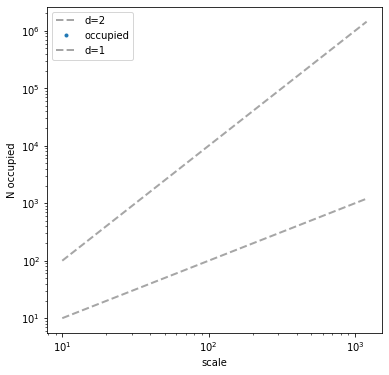

In [7]:
sizes = np.array([10, 50, 100, 200, 500, 800, 1200])
occupied = calc_forest_scaling(sizes)
plot_forest_scaling(sizes, occupied)